In [237]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import model
import patchdata
import cv2

In [238]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = model.VisionTransformer(patch_vec_size=48, num_patches=64, latent_vec_dim=128, num_heads=8, mlp_hidden_dim=64, drop_rate=0., num_layers=12, num_classes=10).to(device)
vit.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [239]:
def minmax(x):
    m = torch.min(x)
    M = torch.max(x)
    return (M-x) / (M-m)

In [240]:
linear_embedding = vit.patchembedding.linear_proj.weight

linear_embedding.shape

torch.Size([128, 48])

In [241]:
rgb_embedding_filters = linear_embedding.detach().cpu().view(3, 4, 4, -1).permute(3, 0, 1, 2)

rgb_embedding_filters.shape

torch.Size([128, 3, 4, 4])

In [242]:
rgb_embedding_filters = minmax(rgb_embedding_filters)

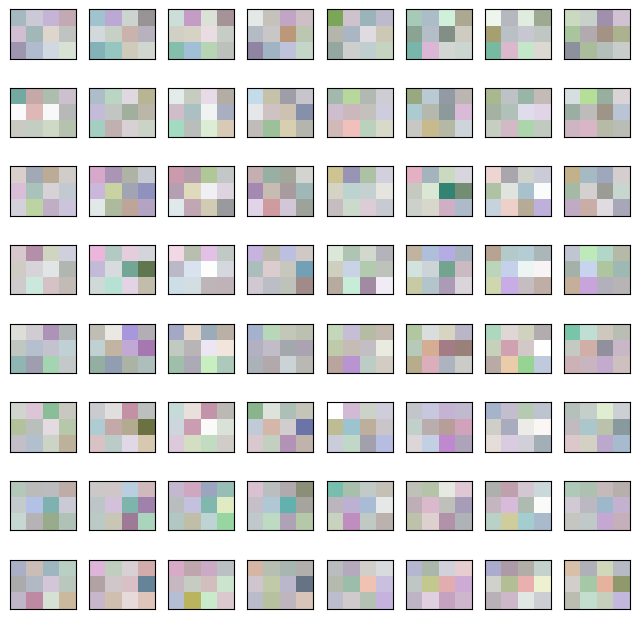

In [243]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 65):
    rgb = rgb_embedding_filters[i-1].numpy()
    ax = fig.add_subplot(8, 8, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(rgb)

In [244]:
pos_embedding = vit.patchembedding.pos_embedding

pos_embedding.shape

torch.Size([1, 65, 128])

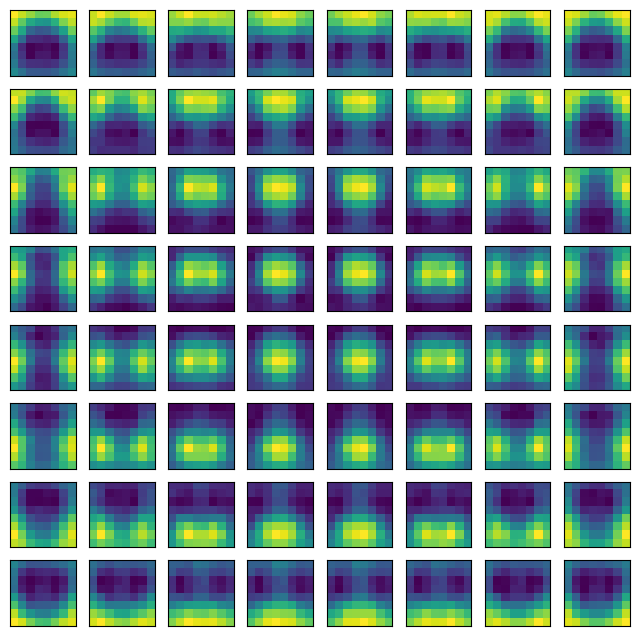

In [245]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
for i in range(1, pos_embedding.shape[1]):
    sim = F.cosine_similarity(pos_embedding[0, i:i+1], pos_embedding[0, 1:], dim=1)
    sim = sim.reshape((8, 8)).detach().cpu().numpy()
    ax = fig.add_subplot(8, 8, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

In [246]:
def imshow(img):
    plt.figure(figsize=(4, 4))
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()
    plt.close()
    return img

In [247]:
def inv_normal(img):
    img = img.reshape(64, -1, 4, 4)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    print(img.size())
    for i in range(img.size(1)):
        img[:, i, :, :] = torch.abs(img[:, i, :, :] * std[i] + mean[i])
    return img

In [248]:
d = patchdata.Flattened2Dpatches(dataname='cifar10', img_size=32, patch_size=4, batch_size=16)
_, _, testloader = d.patchdata()
image_patch, label = next(iter(testloader))
image_patch = image_patch[12:13]

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 4, 4])


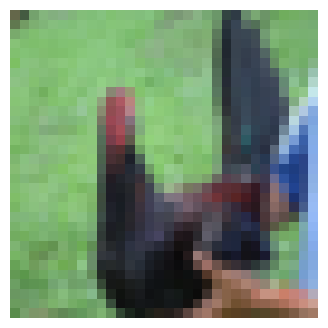

In [249]:
sample = inv_normal(image_patch)
original_img = imshow(torchvision.utils.make_grid(sample, nrow=8, padding=0))

In [250]:
print(original_img.size())

torch.Size([3, 32, 32])


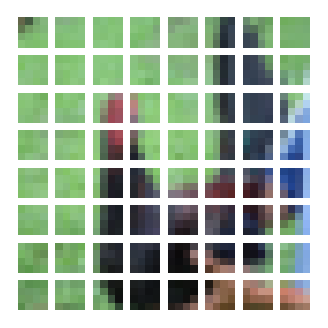

In [251]:
_ = imshow(torchvision.utils.make_grid(sample, nrow=8, padding=1, pad_value=1))

In [252]:
vit.eval()
output, attention = vit(image_patch.to(device))

In [253]:
len(attention), attention[0].shape

(12, torch.Size([1, 8, 65, 65]))

In [254]:
torch.stack(attention).shape, torch.stack(attention).squeeze().shape

(torch.Size([12, 1, 8, 65, 65]), torch.Size([12, 8, 65, 65]))

In [255]:
attention = torch.stack(attention).squeeze(1)

attention.shape

torch.Size([12, 8, 65, 65])

In [256]:
attention_heads = attention.view(-1, 65, 65)
attention_heads = minmax(attention_heads)

attention_heads.shape

torch.Size([96, 65, 65])

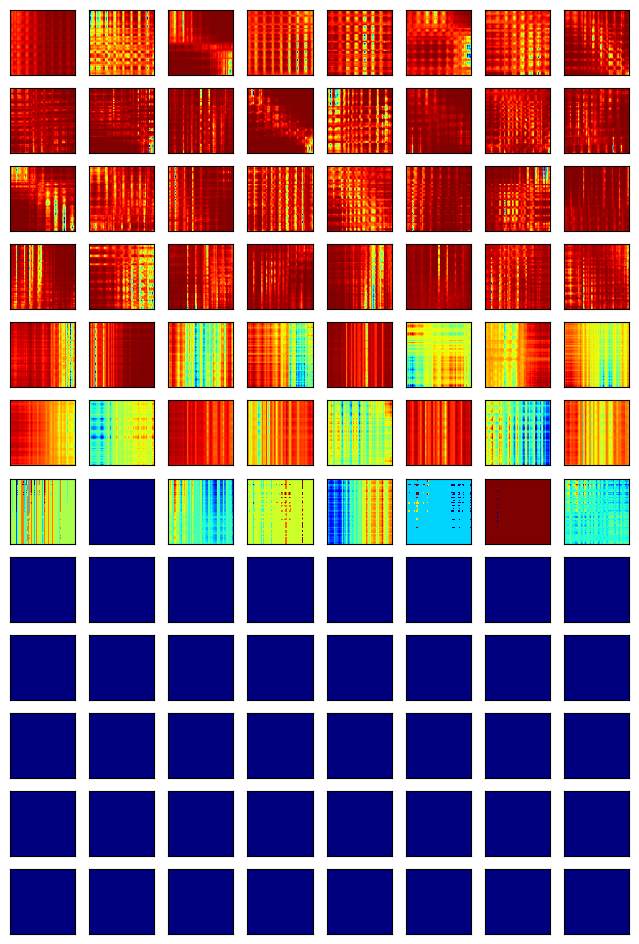

In [257]:
fig = plt.figure(figsize=(8, 12))
for i in range(1, 97):
    result = attention_heads[i-1].detach().cpu().numpy()
    res_tensor = torch.Tensor(result)
    ax = fig.add_subplot(12, 8, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(res_tensor, vmin=np.min(result), vmax=np.max(result), cmap='jet')

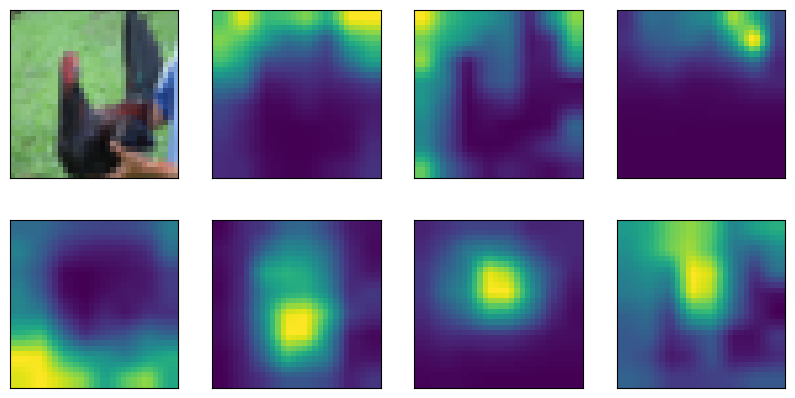

In [258]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 4, 1)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.imshow(original_img.permute(1, 2, 0))
for i in range(7):
    attn_heatmap = attention[0, i, 4, 1:].reshape((8, 8)).detach().cpu().numpy()
    attn_heatmap = cv2.resize(attn_heatmap, (32, 32))
    ax = fig.add_subplot(2, 4, i+2)
    ax.axes.get_xaxis().set_visible(False) #
    ax.axes.get_yaxis().set_visible(False) #
    ax.imshow(attn_heatmap)

In [259]:
for name, param in vit.named_parameters():
    print(name, param.size())

patchembedding.cls_token torch.Size([1, 128])
patchembedding.pos_embedding torch.Size([1, 65, 128])
patchembedding.linear_proj.weight torch.Size([128, 48])
patchembedding.linear_proj.bias torch.Size([128])
transformer.0.ln1.weight torch.Size([128])
transformer.0.ln1.bias torch.Size([128])
transformer.0.ln2.weight torch.Size([128])
transformer.0.ln2.bias torch.Size([128])
transformer.0.msa.query.weight torch.Size([128, 128])
transformer.0.msa.query.bias torch.Size([128])
transformer.0.msa.key.weight torch.Size([128, 128])
transformer.0.msa.key.bias torch.Size([128])
transformer.0.msa.value.weight torch.Size([128, 128])
transformer.0.msa.value.bias torch.Size([128])
transformer.0.mlp.0.weight torch.Size([64, 128])
transformer.0.mlp.0.bias torch.Size([64])
transformer.0.mlp.3.weight torch.Size([128, 64])
transformer.0.mlp.3.bias torch.Size([128])
transformer.1.ln1.weight torch.Size([128])
transformer.1.ln1.bias torch.Size([128])
transformer.1.ln2.weight torch.Size([128])
transformer.1.ln2